In [29]:
"""
The scope of this analysis is to define a model given an article to predict the newspaper from which was published 
taking as input the text of the article itself

"""
import numpy as np 
import pandas as pd 
import os
import re
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
#necessary for using Lemmatization library
import zipfile
with zipfile.ZipFile("/usr/share/nltk_data/corpora/wordnet.zip", mode="r") as archive:
    archive.extractall("/usr/share/nltk_data/corpora")
from nltk.tokenize import word_tokenize
import gc
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler as StdSc
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model._logistic import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [6]:
df = pd.read_csv("/kaggle/input/japanese-newspapers-20052021/english_news.csv",sep = '\t' )
df.head(5)

,source,date,title,author,text
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...


In [7]:
df.describe()

,source,date,title,author,text
count,36889,36889,36889,12846,36766
unique,2,1504,36059,1318,35932
top,The Japan Times,2003-06-06,KANSAI: Who & What,Philip Brasor,This could be due to a conflict with your ad-b...
freq,36815,66,23,318,5


### Cleaning NaN text rows

In [8]:
df.dropna(subset='text', inplace=True, ignore_index = True)

## Distribution of newspapers

In [9]:
df.groupby('source').count()

,date,title,author,text
source,,,,
Mainichi Shimbun,74,74,1,74
The Japan Times,36692,36692,12723,36692


In [10]:
categories = np.unique(df['source'])
print(categories)

['Mainichi Shimbun' 'The Japan Times']



**Analysis done**

Initially has been created a uniform dataset with equal rows for two possible newspapers.
It eventually led to a too small set to train and test models, with just 74 rows for each category, and it would not be representative for the whole dataset in case of second category.

Hence the analysis has been done with the complete dataset considering balanced weights parameter in ML models proportional to the presence of each indipendent feature.

Initially has been created userdefined text preprocessing through nltk libraries but with the wole dataset it consumed too computational resources due to too much possible words for complete analysis. 
Therefore it was used the optimized sklearn library CountVectorizer which, after the text preprocessing, automatically consider the possibility to reduce the number of words for the model. It has been setted all parameters suited to desired configurations.
After train and test on complete dataset the model produced none prediction of the smaller set, also trying with more random_state values.

Finally had been tried an intermediate way to balance the importance of first category and not to loose information about words of second category: had been used all 74 rows of first category and 300 rows of second category, with ML models always in balanced weights mode.
It reported the best model with Random Forest algorithm in terms of precision, recall and accuracy.
It probably should be done with different subsamples of 300 rows each one averaging on results obtained in each model train.


In all cases has been implemented the PCA dimensionality reduction.

The ML models used for the analysis had been:
- K Nearest Neighbors ( used only for balanced dataset )
- Support Vector Machine
- Categorical Regression
- Random Forest
The most efficents seemed to be the ensemble method Random Forest and the SVM algorithm.

An additional small final analysis has been done in function of results of PCA analysis.

## Inital analysis with uniform dataset

### Text preprocessing function

In [30]:
stemming = PorterStemmer()
lemmatization = WordNetLemmatizer()

def text_preprocessing(articles):
    normalized_articles = []
    stop_words = set(stopwords.words('english'))
    for article_text in articles:
        #remove unrelevant characters
        unformatted_text = re.sub(r'[\.\?\!\,\:\;\-\'\’\“\”\(\)\[\]\{\}\"\—\‘\/]', ' ', article_text)
        #Tokenization
        tokenized_text = word_tokenize(unformatted_text)
        #lowering words
        lowercase_tokens = [str.lower(word) for word in tokenized_text]
        #removing stopwords
        cleaned_tokens = [word for word in lowercase_tokens if word not in stop_words]
        #Declination of words and prefix/suffix removal
        stemmed_tokens = [stemming.stem(token) for token in cleaned_tokens]
        normalized_articles.append( [lemmatization.lemmatize(word) for word in stemmed_tokens] )
    
    return normalized_articles

### Obtaining a uniform dataset for two newspapers

In [13]:
w_df = df.sort_values(by='source', inplace = False, ignore_index = True)
n_udf = np.where(w_df['source'] == categories[1])[0][0]
print(n_udf)

74


In [14]:
random.seed(13)
#It generates 74 random numbers between 74 and max length of dataset
randomlist = random.sample(range(n_udf, len(w_df['source'])), n_udf)
#It creates the uniform dataset
udf = pd.concat([w_df.iloc[0:n_udf], w_df.iloc[randomlist]], ignore_index = True)
db_len = len(udf)

### Converting each article in a list of words 

In [15]:
#setted deep copy parameter as True to separate original dataset from working one
w_df = udf.copy(deep = True)

In [16]:
w_df['text'] = text_preprocessing(w_df['text'])


### Obtaining the list of all possible words

In [17]:
words_set = set()
for article_words in w_df['text']:
    words_set.update(article_words)
print('Number of words: ',len(words_set))

Number of words:  6047


### Words count for each article, in particular each percentage presence

In [37]:
def counting_function(texts_column, words_set):
    counts_array= np.zeros(( len(texts_column) , len(words_set) ))
    for i, article_words in enumerate(texts_column):
        for j, word in  enumerate(words_set):        
            counts_array[i,j] =  article_words.count(word) /len(article_words) 
    return counts_array

In [14]:
counts_array = counting_function(w_df['text'], words_set)

Analysis in case of reduced dataset removed because too few data and repetitive with further analysis

# Preprocessing in the case of the whole dataset

In [20]:
w_df = df.copy(deep = True)

New text preprocessing function

In [31]:
def gen_text_preprocessing(texts, max_features=8000):
    for article_text in texts:
        #remove unrelevant characters
        article_text = re.sub(r'[\.\?\!\,\:\;\-\'\’\“\”\(\)\[\]\{\}\"\—\‘\/]', ' ', article_text)
    #the CountVectorizer algorithm removes accents and stop_words according to stop_words list, 
    #does lowercase and it remove less frequent words
    cv = CountVectorizer(strip_accents='unicode',stop_words=list(stopwords.words('english')), max_features = max_features)
    return cv.fit_transform(texts).toarray() , cv.vocabulary_

2D-array as counts of number of times each word, of the unique set of all considered words, appears in a document

In [22]:
X, words_dict = gen_text_preprocessing(w_df['text'])
X

array([[0, 4, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Dictionary of considered words as attribute of CountVectorizer

In [87]:
print(len(words_dict))

8000


## Normalization and Principal Component Analysis

### Rescaling the dataset dependent variables

In [23]:
X_scaled = StdSc(copy=False).fit_transform(X)
X_scaled

array([[-0.02667034, 14.04619401, -0.02760713, ..., -0.05762649,
        -0.03183815, -0.02372879],
       [-0.02667034,  3.36299314, -0.02760713, ..., -0.05762649,
        -0.03183815, -0.02372879],
       [-0.02667034, -0.19807382, -0.02760713, ..., -0.05762649,
        -0.03183815, -0.02372879],
       ...,
       [-0.02667034, -0.19807382, -0.02760713, ..., -0.05762649,
        -0.03183815, -0.02372879],
       [-0.02667034, -0.19807382, -0.02760713, ..., -0.05762649,
        -0.03183815, -0.02372879],
       [-0.02667034, -0.19807382, -0.02760713, ..., -0.05762649,
        -0.03183815, -0.02372879]])

### Identifying best number of components for PCA

In [89]:
pca=PCA().fit(X_scaled)

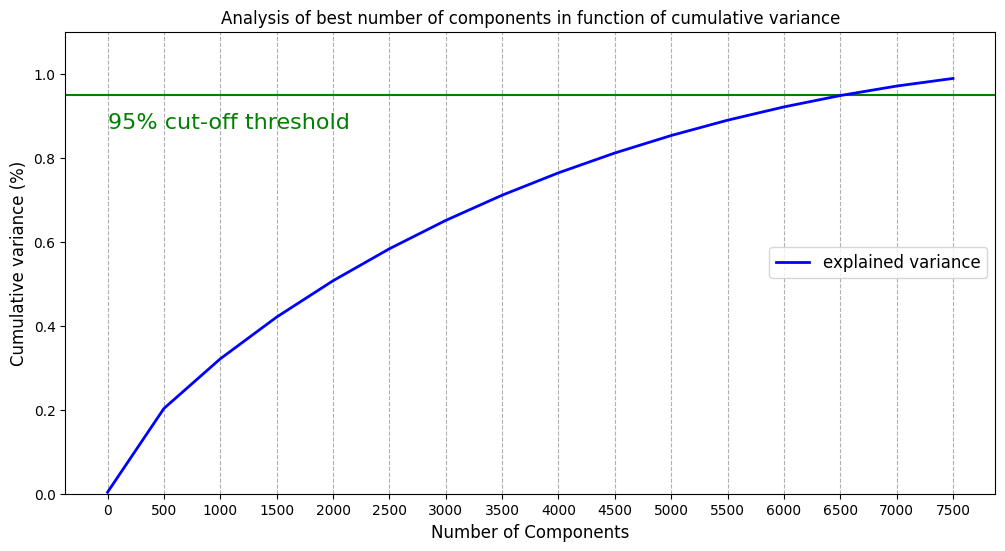

In [92]:
xi = range(0, len(pca.explained_variance_ratio_), 500)
y = np.cumsum(pca.explained_variance_ratio_)[xi]
plt.figure(figsize=(12,6))
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components', fontsize= 12)
plt.xticks(xi) 
plt.ylabel('Cumulative variance (%)', fontsize = 12)
plt.title('Analysis of best number of components in function of cumulative variance')
plt.axhline(y=0.95, color='g', linestyle='-')
plt.text(0.5, 0.87, '95% cut-off threshold', color = 'green', fontsize=16)
plt.grid(axis='x', ls='--')
plt.plot(xi , y , ls='-', color='b', lw=2, label='explained variance')
plt.legend(loc=5, fontsize=12)
plt.savefig('../working/whole_dataset_PCA_analysis.pdf',dpi=600)

Plotting of components values for two categories with PCA reduction with 6500 components

We will can see that for some of reduced variables if their presence was, in absolute value, greater than a small value, it correspond to first category and for other reduced variables it mostly correspond to second category.
We could set a threshold on absolute value of components, but it would reduce too much the training and test dataset and besides probably a model based on these type of selections, like Random Trees, would work fine on this data distribution.

In [ ]:
gc.collect()
pca = PCA(n_components = 6500)
X_reduced_dimension = pca.fit_transform(X_scaled) 

GRAFICO DALL'ELABORAZIONE PESANTE, DI NATURA UGUALE A QUELLO DELLA SUCCESSIVA, CHE E' PRESENTE

In [ ]:
plt.figure(figsize=(16,16))
first_patch = mpatches.Patch(color='red', label= categories[0])
second_patch = mpatches.Patch(color='green', label= categories[1]) 
plt.plot(np.transpose(X_reduced_dimension[np.where(df['source'] == categories[0])]), color='r', marker='.', ls=' ',ms=1.5)
plt.plot(np.transpose(X_reduced_dimension[np.where(df['source'] == categories[1])]), color='g', marker='.', ls=' ',ms=1.5)
plt.xlabel('Single component', size=10)
plt.ylabel('Relative component value', size=10)
plt.legend(handles=[first_patch, second_patch], fontsize=12)
plt.savefig('../working/whole_dataset_components_plot.pdf',dpi=600)

In [ ]:
#Normalization for ML models
X_rescaled = StdSc(copy=False).fit_transform(X_reduced_dimension)
X_rescaled

#### Saving the transformed dataset for upload to speed up in case of future analysis

In [15]:
os.chdir(r'../working')
np.savez_compressed('whole_dataset_prepared_data.npz',X_rescaled=X_rescaled)

In [4]:
with np.load('../working/whole_dataset_prepared_data.npz') as data:
    X_rescaled = data['X_rescaled']

# ML models application

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_rescaled, df['source'], test_size=0.3, random_state=30)

K Nearest Neighbors algorithm was used only for reduced dataset because it does not support the possibility of balanced class weight. 

It could be solved creating a dataset with repeated rows in case of first category less frequest, but was preferable to use other ML algorithms.

In [ ]:
# knn = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1)
# #y_train, y_test = y_train.astype('int'), y_test.astype('int')

# knn.fit(x_train,y_train)
# y_pred = knn.predict(x_test)
# print(metrics.classification_report(y_test, y_pred, zero_division=0))

In [ ]:
# print(metrics.confusion_matrix(y_test,y_pred))

In [ ]:
# #to choose best number of neighbors to consider
# scores = []
# for k in range(1,15):
#     knn = KNeighborsClassifier(n_neighbors=k)
#     score = cross_val_score(knn, x_test, y_test, cv=5)
#     scores.append(np.mean(score))
# scores

## Support Vectors Machine algorithm

In [20]:
gc.collect()
svc = SVC( class_weight = 'balanced')
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)

In [21]:
print(metrics.classification_report(y_test, y_pred, zero_division=0))

                  precision    recall  f1-score   support

Mainichi Shimbun       0.00      0.00      0.00        24
 The Japan Times       1.00      1.00      1.00     11006

        accuracy                           1.00     11030
       macro avg       0.50      0.50      0.50     11030
    weighted avg       1.00      1.00      1.00     11030



In [22]:
print(metrics.confusion_matrix(y_test,y_pred))

[[    0    24]
 [    0 11006]]


## Logistic regression

In [23]:
gc.collect()
#solver='newton-cholesky' is indicated in case of n_variables >> n_features
lr = LogisticRegression(solver='newton-cholesky', class_weight ='balanced',n_jobs=-1)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

In [24]:
print(metrics.classification_report(y_test, y_pred, zero_division=0))

                  precision    recall  f1-score   support

Mainichi Shimbun       0.00      0.00      0.00        24
 The Japan Times       1.00      1.00      1.00     11006

        accuracy                           1.00     11030
       macro avg       0.50      0.50      0.50     11030
    weighted avg       1.00      1.00      1.00     11030



In [25]:
print(metrics.confusion_matrix(y_test,y_pred))

[[    0    24]
 [    0 11006]]


## Random Forest model

In [12]:
gc.collect()
forest = RandomForestClassifier( class_weight = 'balanced', n_jobs=-1, random_state=100)
forest.fit(x_train,y_train)
y_pred = forest.predict(x_test)

In [13]:
print(metrics.classification_report(y_test, y_pred, zero_division=0))

                  precision    recall  f1-score   support

Mainichi Shimbun       0.00      0.00      0.00        24
 The Japan Times       1.00      1.00      1.00     11006

        accuracy                           1.00     11030
       macro avg       0.50      0.50      0.50     11030
    weighted avg       1.00      1.00      1.00     11030



In [14]:
print(metrics.confusion_matrix(y_test,y_pred))

[[    0    24]
 [    0 11006]]


## ROC Curve

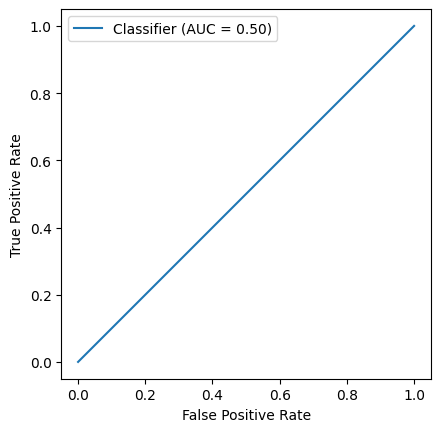

In [15]:
RocCurveDisplay.from_predictions([0 if i==categories[0] else 1  for i in y_test],[0 if i==categories[0] else 1  for i in y_pred])
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

All models produced bad predictions for first category due to too few rows for first category with respect to the second one.

It can be seen from confusion matrices with support for first category of only 24 compared to 11006 of second category.

So the accuracy of 1 does not represent at all the real accuracy of the models because they have 0 precision for the first category.

Also the ROC curve for supposed best model (Random Forest) reported a lot of False Positives.

Therefore the analysis proceded with another final subset for creating the ML model.

# Training the model on all articles of first newspaper and a subset of articles for second newspaper

### Creating dataset

In [92]:
w_df = df.sort_values(by='source', inplace = False, ignore_index = True)
n_udf = np.where(w_df['source'] == categories[1])[0][0]
print(n_udf)

74


In [93]:
random.seed(13)
#It generates 74 random numbers between 74 and max length of dataset
randomlist = random.sample(range(n_udf, len(df['source'])), 300)
udf = pd.concat([w_df.iloc[0:n_udf], w_df.iloc[randomlist]], ignore_index = True)

### Text preprocessing and words presence counts

Comparing number of unique words in case of two text_preprocessing functions

In [32]:
X, words_dict = gen_text_preprocessing(udf['text'])
len(words_dict)

8000

In [94]:
udf['text'] = text_preprocessing(udf['text'])

In [98]:
words_set = set()
for article_words in udf['text']:
    words_set.update(article_words)
print('Number of words: ',len(words_set))

Number of words:  7519


The number of words considered are less in case of user defined text preprocessing function hence it will be considered for preprocessing of this dataset because it is more selective without excluding words in function of their frequencies (which instead CountVectorize does with max_features parameter).

In [99]:
X = counting_function(udf['text'],words_set)

In [100]:
X_scaled = StdSc(copy=False).fit_transform(X)

### PCA analysis

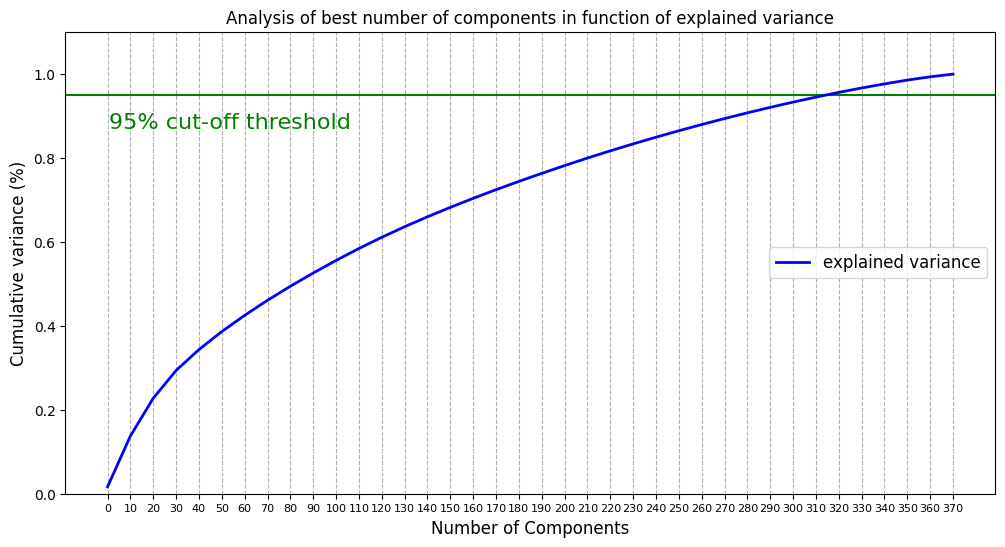

In [67]:
pca=PCA().fit(X_scaled)

xi = range(0, len(pca.explained_variance_ratio_) , 10)
y = np.cumsum(pca.explained_variance_ratio_)[xi]
plt.figure(figsize=(12,6))
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components', fontsize= 12)
plt.xticks(xi, fontsize = 8) 
plt.ylabel('Cumulative variance (%)', fontsize = 12)
plt.title('Analysis of best number of components in function of explained variance')
plt.axhline(y=0.95, color='g', linestyle='-')
plt.text(0.5, 0.87, '95% cut-off threshold', color = 'green', fontsize=16)
plt.grid(axis='x', ls='--')
plt.plot(xi , y , ls='-', color='b', lw=2, label='explained variance')
plt.legend(loc=5, fontsize=12)
plt.savefig('../working/final_PCA_analysis.pdf',dpi=600)

In [101]:
pca=PCA(n_components = 315)
X_reduced=pca.fit_transform(X_scaled)
X_reduced_dimension = pca.fit_transform(X_scaled) 

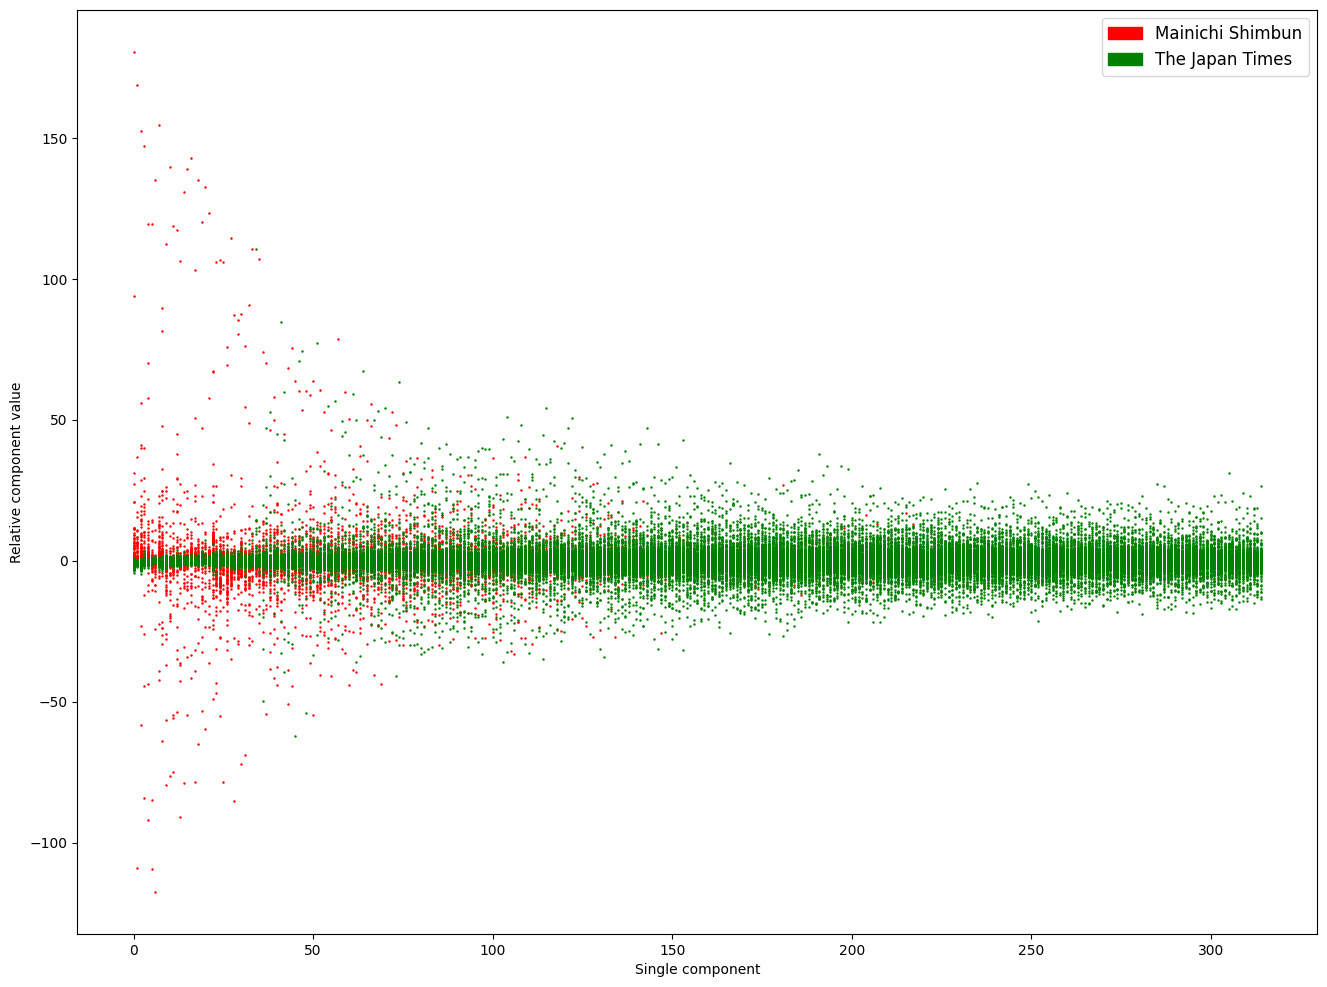

In [51]:
plt.figure(figsize=(16,12))
first_patch = mpatches.Patch(color='red', label= categories[0])
second_patch = mpatches.Patch(color='green', label= categories[1]) 
plt.plot(np.transpose(X_reduced_dimension[np.where(udf['source'] == categories[0])]), color='r', marker='.', ls=' ',ms=1.5)
plt.plot(np.transpose(X_reduced_dimension[np.where(udf['source'] == categories[1])]), color='g', marker='.', ls=' ',ms=1.5)
plt.xlabel('Single component', size=10)
plt.ylabel('Relative component value', size=10)
plt.legend(handles=[first_patch, second_patch], fontsize=12, loc='best')
plt.savefig('../working/final_components_plot.pdf',dpi=600)

In [102]:
X_rescaled = StdSc(copy=False).fit_transform(X)

## ML models train and test

In [103]:
x_train, x_test, y_train, y_test = train_test_split(X_rescaled, udf['source'], test_size=0.3, random_state=30)

#### SVM model

In [104]:
gc.collect()
svc = SVC( class_weight = 'balanced')
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)

In [105]:
print('Classification report: \n \n',metrics.classification_report(y_test, y_pred, zero_division=0))
print('\n Confusion matrix: \n', metrics.confusion_matrix(y_test, y_pred))

Classification report: 
 
                   precision    recall  f1-score   support

Mainichi Shimbun       0.76      0.84      0.80        19
 The Japan Times       0.97      0.95      0.96        94

        accuracy                           0.93       113
       macro avg       0.86      0.89      0.88       113
    weighted avg       0.93      0.93      0.93       113


 Confusion matrix: 
 [[16  3]
 [ 5 89]]


#### Logistic Regression

In [106]:
lr = LogisticRegression(solver='newton-cholesky',class_weight ='balanced',n_jobs=-1)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

In [107]:
print('Classification report: \n \n',metrics.classification_report(y_test, y_pred, zero_division=0))
print('\n Confusion matrix: \n', metrics.confusion_matrix(y_test, y_pred))

Classification report: 
 
                   precision    recall  f1-score   support

Mainichi Shimbun       1.00      0.42      0.59        19
 The Japan Times       0.90      1.00      0.94        94

        accuracy                           0.90       113
       macro avg       0.95      0.71      0.77       113
    weighted avg       0.91      0.90      0.89       113


 Confusion matrix: 
 [[ 8 11]
 [ 0 94]]


#### Random Forest

In [108]:
forest = RandomForestClassifier( class_weight = 'balanced', n_jobs=-1, random_state=100) #class_weight = 'balanced_subsample'
forest.fit(x_train,y_train)
y_pred = forest.predict(x_test)

In [109]:
print('Classification report: \n \n',metrics.classification_report(y_test, y_pred, zero_division=0))
print('\n Confusion matrix: \n', metrics.confusion_matrix(y_test, y_pred))

Classification report: 
 
                   precision    recall  f1-score   support

Mainichi Shimbun       1.00      1.00      1.00        19
 The Japan Times       1.00      1.00      1.00        94

        accuracy                           1.00       113
       macro avg       1.00      1.00      1.00       113
    weighted avg       1.00      1.00      1.00       113


 Confusion matrix: 
 [[19  0]
 [ 0 94]]


#### ROC Curve for SVM model

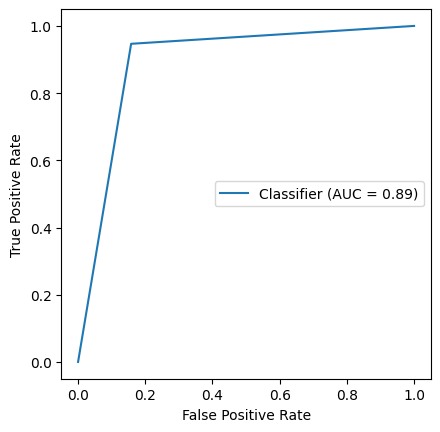

In [110]:
svc = SVC( class_weight = 'balanced')
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)

RocCurveDisplay.from_predictions([0 if i==categories[0] else 1  for i in y_test],[0 if i==categories[0] else 1  for i in y_pred])
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=5)
plt.show()

It can be seen performance of the Random Forest model as perfects so it suggests as this set could bring to overfitting for Random Forest model.
The SVC model seems to be good in terms of precisions and recalls for two categories. It can be seen also from confusion matrix.

With this dataset from confusion matrices it can be seen that for both two categories the accuracy really represent the accuracy of the model because the support for the two categories are both non zero.

The ROC curve reports a 'Area Under Curve' about 89%. It should be a bit more.

This analysis should be done with more subsets of 74 rows of first category and 300 rows of second one or trying with different number of rows for second category.

##### It had been tried a supplementary analysis removing central variables which have mixed values for both categories.
It reported interesting prediction values for Random Forest algorithm.


In [87]:
x_train, x_test, y_train, y_test = train_test_split(np.append(X_rescaled[::,0:40],X_rescaled[::,200:315],axis=1), udf['source'], test_size=0.3, random_state=30)

In [88]:
gc.collect()
svc = SVC( class_weight = 'balanced')
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)

In [89]:
print('Classification report: \n \n',metrics.classification_report(y_test, y_pred, zero_division=0))
print('\n Confusion matrix: \n', metrics.confusion_matrix(y_test, y_pred))

Classification report: 
 
                   precision    recall  f1-score   support

Mainichi Shimbun       0.11      0.05      0.07        19
 The Japan Times       0.83      0.91      0.87        94

        accuracy                           0.77       113
       macro avg       0.47      0.48      0.47       113
    weighted avg       0.71      0.77      0.73       113


 Confusion matrix: 
 [[ 1 18]
 [ 8 86]]


In [90]:
gc.collect()
forest = RandomForestClassifier( class_weight = 'balanced_subsample', n_jobs=-1, random_state=100) #class_weight = 'balanced_subsample'
forest.fit(x_train,y_train)
y_pred = forest.predict(x_test)

In [91]:
print('Classification report: \n \n',metrics.classification_report(y_test, y_pred, zero_division=0))
print('\n Confusion matrix: \n', metrics.confusion_matrix(y_test, y_pred))

Classification report: 
 
                   precision    recall  f1-score   support

Mainichi Shimbun       0.88      0.74      0.80        19
 The Japan Times       0.95      0.98      0.96        94

        accuracy                           0.94       113
       macro avg       0.91      0.86      0.88       113
    weighted avg       0.94      0.94      0.94       113


 Confusion matrix: 
 [[14  5]
 [ 2 92]]
